In [127]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic
from sklearn.impute import SimpleImputer

# Условие

- Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/
2- Для 151 406 договоров страхования транспортных средств известны значения ряда признаков,
в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель,
год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1,
 если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

- Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

- В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);

variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);

variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);

variable_4 - идентификатор года выпуска транспортного средства;

variable_5 - идентификатор страны - производителя транспортного средства;

variable_6 - мощность двигателя в лошадиных силах;

variable_7 - объем двигателя в куб. см;

variable_8 - идентификатор стороны расположения руля (левый или правый);

variable_9 - пробег транспортного средства, покрываемый гарантией производителя;

variable_10 - индикатор действия гарантии на транспортное средство;

variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;

variable_12 - возраст транспортного средства (в мес.);

variable_13 - возраст водителя с максимальным стажем;

variable_14 - коэффициент возраст-стаж;

variable_15 - коэффициент краткосрочности;

variable_16 - коэффициент мощности;

variable_17 - коэффициент "мультидрайв";

variable_18 - территориальный коэффициент;

variable_19 - коэффициент "КНДР";

variable_20 - идентификатор канала продаж;

variable_21 - марка транспортного средства;

variable_22 - модель транспортного средства;

variable_23 - индикатор отечественных транспортных средств;

variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";

variable_25 - индикатор пролонгации;

variable_26 - индикатор совпадения собственника транспортного средства и водителя;

variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";

variable_28 - тип транспортного средства;

target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.

In [146]:
TEST_DATA_NUM = 22624

# Подготовка данных 

### 1 Уничтожаем NaN

In [128]:
init_df = pd.read_csv('insclass_train.csv')
# считаем кол-во NaN
keys_with_nan = init_df.isna().sum()    
# ic(f'All NaN sum \n{keys_with_nan}')
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan


variable_6        111
variable_7      95639
variable_8      29899
variable_9     134436
variable_12      1528
variable_13      1657
variable_14      2927
variable_15    151393
variable_16        12
variable_17        12
variable_18        12
variable_20         1
variable_24      2207
variable_27      2067
dtype: int64

In [129]:
refacted_df = init_df.copy().drop(['variable_9', 'variable_15'], axis=1)
keys_with_nan = keys_with_nan.drop(labels=['variable_9', 'variable_15'])
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,w200,0,0,14,q2,98.0,NaN,0.0,0,0,...,C,j2,h45,0,0.0,0,1,19.323463,t1,0
1,w160,0,0,7,q11,106.0,NaN,0.0,0,0,...,C,j33,h234,0,1.0,0,1,41.177900,t1,0
2,w200,0,0,4,q3,123.0,NaN,0.0,0,0,...,B,j12,h28,0,0.0,0,1,3.614395,t1,0
3,w200,0,0,9,q3,102.0,NaN,0.0,0,0,...,C,j12,h64,0,1.0,0,0,49.041674,t1,0
4,w200,0,0,18,q20,117.0,NaN,0.0,0,0,...,C,j111,h991,0,1.0,0,0,17.909612,t1,0


In [130]:
nan_row_idx = refacted_df.loc[pd.isna(refacted_df['variable_20']), :].index[0]
ic(nan_row_idx)
ic(refacted_df.shape)
refacted_df = refacted_df.drop([nan_row_idx])
ic(refacted_df.shape)



ic| nan_row_idx: 109113
ic| refacted_df.shape: (151406

, 27)
ic| refacted_df.shape: (151405, 27)


(151405, 27)

In [131]:
keys_with_nan = refacted_df.isna().sum()    
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan

variable_6       111
variable_7     95639
variable_8     29898
variable_12     1528
variable_13     1657
variable_14     2927
variable_16       12
variable_17       12
variable_18       12
variable_24     2207
variable_27     2067
dtype: int64

In [132]:
refacted_df[keys_with_nan.index].info()

<class 'pandas.core.frame.DataFrame'>
Index: 151405 entries, 0 to 151405
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_6   151294 non-null  float64
 1   variable_7   55766 non-null   float64
 2   variable_8   121507 non-null  float64
 3   variable_12  149877 non-null  float64
 4   variable_13  149748 non-null  float64
 5   variable_14  148478 non-null  float64
 6   variable_16  151393 non-null  float64
 7   variable_17  151393 non-null  float64
 8   variable_18  151393 non-null  float64
 9   variable_24  149198 non-null  float64
 10  variable_27  149338 non-null  float64
dtypes: float64(11)
memory usage: 13.9 MB


In [133]:

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(refacted_df[keys_with_nan.index])

refacted_df[keys_with_nan.index] = imputer.transform(refacted_df[keys_with_nan.index])
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,w200,0,0,14,q2,98.0,1865.914572,0.0,0,0,...,C,j2,h45,0,0.0,0,1,19.323463,t1,0
1,w160,0,0,7,q11,106.0,1865.914572,0.0,0,0,...,C,j33,h234,0,1.0,0,1,41.177900,t1,0
2,w200,0,0,4,q3,123.0,1865.914572,0.0,0,0,...,B,j12,h28,0,0.0,0,1,3.614395,t1,0
3,w200,0,0,9,q3,102.0,1865.914572,0.0,0,0,...,C,j12,h64,0,1.0,0,0,49.041674,t1,0
4,w200,0,0,18,q20,117.0,1865.914572,0.0,0,0,...,C,j111,h991,0,1.0,0,0,17.909612,t1,0


Проверка на NaN

In [134]:
keys_with_nan = refacted_df.isna().sum()
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan

Series([], dtype: int64)

### 2 Энкодим строковые факторы

In [153]:
refacted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151405 entries, 0 to 151405
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_1   151405 non-null  object 
 1   variable_2   151405 non-null  int64  
 2   variable_3   151405 non-null  int64  
 3   variable_4   151405 non-null  int64  
 4   variable_5   151405 non-null  object 
 5   variable_6   151405 non-null  float64
 6   variable_7   151405 non-null  float64
 7   variable_8   151405 non-null  float64
 8   variable_10  151405 non-null  int64  
 9   variable_11  151405 non-null  int64  
 10  variable_12  151405 non-null  float64
 11  variable_13  151405 non-null  float64
 12  variable_14  151405 non-null  float64
 13  variable_16  151405 non-null  float64
 14  variable_17  151405 non-null  float64
 15  variable_18  151405 non-null  float64
 16  variable_19  151405 non-null  float64
 17  variable_20  151405 non-null  object 
 18  variable_21  151405 non-null 

In [163]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

need_encoding_cols = refacted_df.select_dtypes(include='object').columns

for col_name in need_encoding_cols:

    label_encoder.fit(refacted_df[col_name].unique())
    refacted_df[col_name] = label_encoder.transform(refacted_df[col_name])

refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,8,0,0,14,12,98.0,1865.914572,0.0,0,0,...,2,92,910,0,0.0,0,1,19.323463,0,0
1,4,0,0,7,3,106.0,1865.914572,0.0,0,0,...,2,123,679,0,1.0,0,1,41.177900,0,0
2,8,0,0,4,23,123.0,1865.914572,0.0,0,0,...,1,23,728,0,0.0,0,1,3.614395,0,0
3,8,0,0,9,23,102.0,1865.914572,0.0,0,0,...,2,23,1112,0,1.0,0,0,49.041674,0,0
4,8,0,0,18,13,117.0,1865.914572,0.0,0,0,...,2,14,1467,0,1.0,0,0,17.909612,0,0


In [165]:
refacted_df.sum()

variable_1     8.507210e+05
variable_2     2.581000e+03
variable_3     0.000000e+00
variable_4     1.712044e+06
variable_5     2.540826e+06
variable_6     1.785638e+07
variable_7     2.825088e+08
variable_8     5.108846e+01
variable_10    2.629000e+03
variable_11    2.958000e+03
variable_12    2.015206e+07
variable_13    7.566498e+06
variable_14    1.329571e+07
variable_16    2.002685e+07
variable_17    1.294628e+07
variable_18    1.652811e+07
variable_19    2.118360e+07
variable_20    2.355460e+05
variable_21    1.389600e+07
variable_22    1.227117e+08
variable_23    3.054800e+04
variable_24    1.116008e+05
variable_25    1.477900e+04
variable_26    1.305960e+05
variable_27    2.354548e+06
variable_28    2.675000e+03
target         1.445900e+04
dtype: float64

Кажется variable_3 бесполезный признак

In [166]:
(refacted_df['variable_3'] != 0).sum()

0

In [168]:
refacted_df = refacted_df.drop(['variable_3'], axis=1)
refacted_df.head()

KeyError: "['variable_3'] not found in axis"

### 3 Нормируем факторные признаки

In [164]:
def mean_from_df(df: pd.DataFrame) -> float:
    """Можно пихать срезы."""
    means = df.mean()
    return sum(means) / len(means)

def norm_by_target(target_mean: float, not_normed_1d_arr: pd.Series):
    not_normed_mean = not_normed_1d_arr.mean()
    norm_coef = target_mean / not_normed_mean
    return not_normed_1d_arr * norm_coef

In [ ]:
for_mean_cols = ['variable_2', 'variable_10', 'variable_11', 'variable_28']
ic(refacted_df[for_mean_cols].sum())
target_mean = mean_from_df(refacted_df[for_mean_cols])



### 4 И только теперь сохраняем файл с тестовыми данными

In [147]:
refacted_df.sample(n=TEST_DATA_NUM, random_state=1).to_csv('insclass_test.csv', index=False)

# Проверка сбалансированности датасета

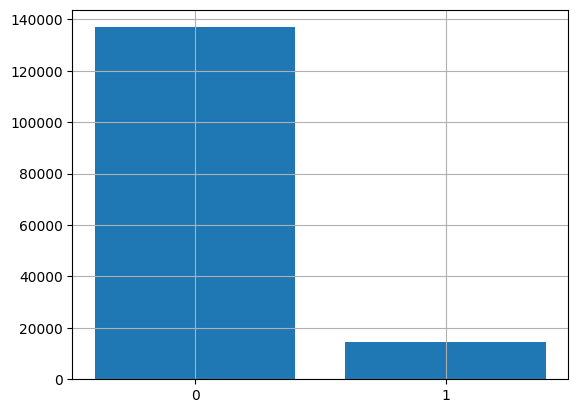

In [138]:
null_class_objs_count = (refacted_df['target'] == 0).sum()
first_class_objs_count = (refacted_df['target'] == 1).sum()
plt.figure()
plt.bar(['0', '1'], [null_class_objs_count, first_class_objs_count])



# Балансируем датасет

In [141]:
zero_target_df_part = refacted_df[refacted_df['target'] == 0].sample(n=first_class_objs_count, random_state=1)
# проверка 
ic(zero_target_df_part.shape)
ic((zero_target_df_part['target'] == 0).sum())
ic(first_class_objs_count)

ic| 

zero_target_df_part.shape: (14459, 27)
ic| (zero_target_df_part['target'] == 0).sum(): 14459
ic| first_class_objs_count: 14459


14459

In [144]:
first_target_df_part = refacted_df[refacted_df['target'] == 1]
balanced_df = pd.concat((zero_target_df_part, first_target_df_part), axis=0)
balanced_df.head()


,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
66095,w160,0,0,10,q0,129.0,1762.000000,0.000000,0,0,...,C,j4,h17,0,1.0,0,1,34.495924,t1,0
98195,w200,0,0,6,q3,123.0,1591.000000,0.000337,0,0,...,A,j12,h28,0,0.0,0,1,2.249316,t1,0
37078,w160,0,0,5,q7,104.7,1865.914572,0.000000,0,0,...,C,j11,h58,0,0.0,0,1,10.763031,t1,0
9297,w160,0,0,11,q3,109.0,1865.914572,0.000000,0,0,...,C,j3,h3,0,1.0,0,1,7.883271,t1,0
110958,w200,0,0,10,q1,140.0,1796.000000,0.000337,0,0,...,A,j1,h24,0,0.0,0,1,2.249316,t1,0


Проверка

<BarContainer object of 2 artists>

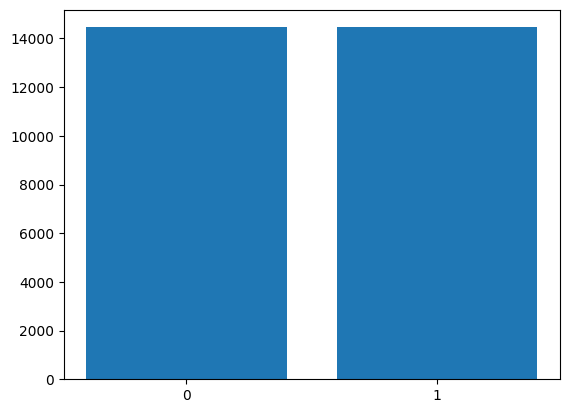

In [145]:
null_class_objs_count = (balanced_df['target'] == 0).sum()
first_class_objs_count = (balanced_df['target'] == 1).sum()
plt.figure()
plt.bar(['0', '1'], [null_class_objs_count, first_class_objs_count])

# Модель 

In [151]:

class LogisticRegressionGD(object):
    def __init__(self):
        self.a = np.zeros(2).reshape(1, 2)
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x @ self.a))      # вектор x нужно дополнить нулевым значением в начале 
    def predict(self, x):
        return self.sigmoid(x)
    def coefs(self):
        return self.a
    def LogLikelihood(self, x, Y):
        return 0
    def CrossEntropy(self, x, Y):
        return (-Y*np.log(self.predict(x)) - (1- Y)*np.log(1 - self.predict(x))).sum()

    def accuracy(self, x, Y):
        return 0
    
    def fit(self, x, Y, alpha = 0.001, epsylon = 0.01, max_steps = 5000, Rtype = "LL"):
        self.a = np.zeros (x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dT_a = 0
                self.a += alpha*dT_a
            elif Rtype == "CE":
                new_error = self.CrossEntropy(x, Y)
                #display(new_error)
                dT_a = -x.T @(Y - self.predict(x))
                self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)
            if new_error < epsylon:
               break
        return steps, errors

# Обучение модели

In [149]:
x = balanced_df.copy()
x.insert(0, 'zero_col', np.zeros(x.shape[0]))
x.head()

,zero_col,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
66095,0.0,w160,0,0,10,q0,129.0,1762.000000,0.000000,0,...,C,j4,h17,0,1.0,0,1,34.495924,t1,0
98195,0.0,w200,0,0,6,q3,123.0,1591.000000,0.000337,0,...,A,j12,h28,0,0.0,0,1,2.249316,t1,0
37078,0.0,w160,0,0,5,q7,104.7,1865.914572,0.000000,0,...,C,j11,h58,0,0.0,0,1,10.763031,t1,0
9297,0.0,w160,0,0,11,q3,109.0,1865.914572,0.000000,0,...,C,j3,h3,0,1.0,0,1,7.883271,t1,0
110958,0.0,w200,0,0,10,q1,140.0,1796.000000,0.000337,0,...,A,j1,h24,0,0.0,0,1,2.249316,t1,0


In [152]:

log_classification = LogisticRegressionGD()
log_classification.fit(x, x['target'],  alpha = 0.001, epsylon = 0.01, max_steps = 5000, Rtype = "CE")

TypeError: bad operand type for unary -: 'str'